In [1]:
import glob

import cartopy.crs as ccrs
import cftime
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import om4labs.om4common as om4
import pandas as pd
import scipy.signal as signal
import xarray as xr
from eofs.xarray import Eof

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

out_path_fig = "/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/"
out_path_data = "/work/Katherine.Turner/smaller_projects/hifreq-variability/data/"

In [87]:
mod = 'CM4'
ds = xr.open_dataset(
    f"/work/Katherine.Turner/smaller_projects/hifreq-variability/data/{mod}_cmip_monthly_storms.nc",
    use_cftime=True,
)

In [88]:
storms_seasonal = ds.center_counts.resample(time="QS-DEC").sum()
# storms_translation = ds.translation_avg.resample(time="QS-DEC").mean()

In [89]:
idx_jja = storms_seasonal.time.dt.month == 6
idx_djf = storms_seasonal.time.dt.month == 12

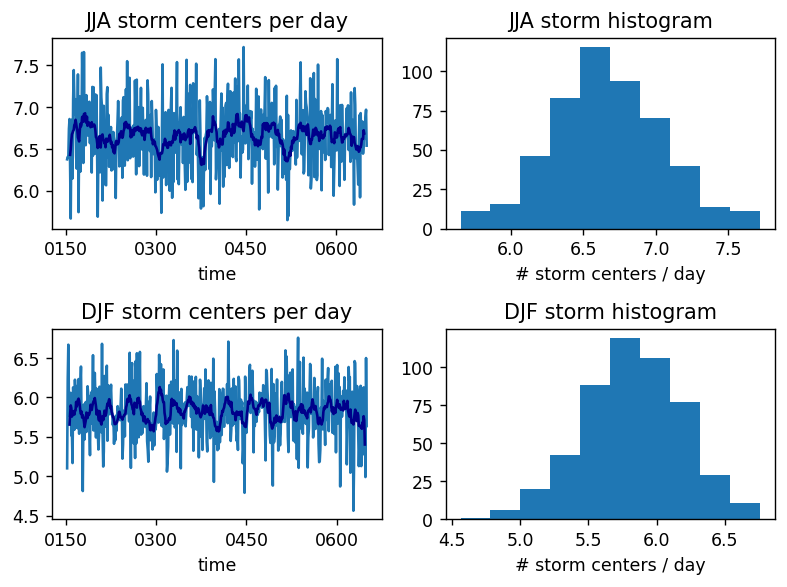

In [30]:
fig, axs = plt.subplots(ncols=2, nrows=2, dpi=125)
axs = axs.flatten()

(1 / (92 * 4) * storms_seasonal)[idx_jja].plot(ax=axs[0])
(1 / (92 * 4) * storms_seasonal)[idx_jja].rolling(time=10, center=True).mean().plot(
    ax=axs[0], color="darkblue"
)
axs[0].set_title("JJA storm centers per day")

(1 / (92 * 4) * storms_seasonal)[idx_jja].plot.hist(ax=axs[1])
axs[1].set_title("JJA storm histogram")
axs[1].set_xlabel("# storm centers / day")

(1 / (90 * 4) * storms_seasonal)[idx_djf][1:-1].plot(ax=axs[2])
(1 / (90 * 4) * storms_seasonal)[idx_djf].rolling(time=10, center=True).mean().plot(
    ax=axs[2], color="darkblue"
)
axs[2].set_title("DJF storm centers per day")

(1 / (90 * 4) * storms_seasonal)[idx_djf][1:-1].plot.hist(ax=axs[3])
axs[3].set_title("DJF storm histogram")
axs[3].set_xlabel("# storm centers / day")

for i in range(4):
    axs[i].set_ylabel("")

plt.tight_layout()
plt.savefig(f"{out_path_fig}{mod}_cmip_storm_distributions.png", format="png", dpi=100)

## Finding high-storm and low-storm years

In [90]:
storms_djf = storms_seasonal[idx_djf][1:-1]
storms_jja = storms_seasonal[idx_jja]
storms_djf.mean(), storms_jja.mean()

(<xarray.DataArray 'center_counts' ()>
 array(2096.85571142),
 <xarray.DataArray 'center_counts' ()>
 array(2451.556))

In [91]:
lo_djf = storms_djf.sortby(storms_djf).time[:50]
hi_djf = storms_djf.sortby(storms_djf).time[-50:]

idx_hi_djf = storms_djf.time.isin(hi_djf)
idx_lo_djf = storms_djf.time.isin(lo_djf)

storms_djf[idx_hi_djf].mean(), storms_djf[idx_lo_djf].mean()

(<xarray.DataArray 'center_counts' ()>
 array(2318.46),
 <xarray.DataArray 'center_counts' ()>
 array(1861.68))

In [92]:
lo_jja = storms_jja.sortby(storms_jja).time[:50]
hi_jja = storms_jja.sortby(storms_jja).time[-50:]

idx_hi_jja = storms_jja.time.isin(hi_jja)
idx_lo_jja = storms_jja.time.isin(lo_jja)

storms_jja[idx_hi_jja].mean(), storms_jja[idx_lo_jja].mean()

(<xarray.DataArray 'center_counts' ()>
 array(2704.38),
 <xarray.DataArray 'center_counts' ()>
 array(2205.96))

In [30]:
tspeed_djf = storms_translation[idx_djf][1:-1]
tspeed_jja = storms_translation[idx_jja]

tspeed_djf[idx_hi_djf].mean(), tspeed_djf[idx_lo_djf].mean()

# tspeed_jja[idx_hi_jja].mean(), tspeed_jja[idx_lo_jja].mean()

# tspeed_djf.mean(), tspeed_djf.std()

(<xarray.DataArray 'translation_avg' ()>
 array(926.03300075),
 <xarray.DataArray 'translation_avg' ()>
 array(949.07622366))

In [ ]:
event_counts = np.zeros(len(year_counts_winter))
mean_slp = np.zeros(len(year_counts_winter))
mean_windmax = np.zeros(len(year_counts_winter))
for i, year in enumerate(year_counts_winter.index):
    event_counts[i] = len(df_winter[df_winter["Year"] == year]["Event"].value_counts())
    mean_slp[i] = df_winter[df_winter["Year"] == year]["SLP"].mean()
    mean_windmax[i] = df_winter[df_winter["Year"] == year]["Windspeed"].mean()

fig, axs = plt.subplots(ncols=2, figsize=(6, 3))
axs[0].scatter(year_counts_winter, 1e-2 * mean_slp)
axs[1].scatter(year_counts_winter, mean_windmax)

axs[0].set_ylabel("SLP low (hPa)")
axs[0].set_xlabel("Storm centers per winter")

axs[1].set_ylabel("Max windspeed (m s$^{-1}$)")
axs[1].set_xlabel("Storm centers per winter")
# np.corrcoef(year_counts, mean_windmax)
plt.tight_layout()

## Creating maps of storm locations for climatology, strongest 10%, and weakest 10%

In [47]:
files = glob.glob(
    f"/work/Katherine.Turner/tempest-extremes/{mod}_cmip/comp_slp/masked*.nc"
)

for file in files:
    ds_mask = xr.open_dataset(file, use_cftime=True)
    da = ds_mask.mask.resample(time="M").sum()
    da.to_dataset(name="mask").to_netcdf(
        f"/work/Katherine.Turner/tempest-extremes/{mod}_cmip/mask/mask_{file[-12:]}"
    )
    del da, ds_mask

In [93]:
ds_mask = xr.open_mfdataset(
    f"/work/Katherine.Turner/tempest-extremes/{mod}_cmip/mask/mask_*.nc", use_cftime=True
)
ds_static = xr.open_dataset(
    f"/work/Katherine.Turner/tempest-extremes/{mod}_cmip/data/atmos.static.nc"
)

In [10]:
landmask = ds_static.land_mask > 0.3

In [94]:
midx_djf = ds_mask.time.dt.month.isin([1, 2, 12])
midx_jja = ds_mask.time.dt.month.isin([6, 7, 8])

midx_hi_djf = (
    ds_mask.time.dt.year.isin(hi_djf.dt.year) & ds_mask.time.dt.month.isin([12])
) | (ds_mask.time.dt.year.isin(hi_djf.dt.year + 1) & ds_mask.time.dt.month.isin([1, 2]))
midx_lo_djf = (
    ds_mask.time.dt.year.isin(lo_djf.dt.year) & ds_mask.time.dt.month.isin([12])
) | (ds_mask.time.dt.year.isin(lo_djf.dt.year + 1) & ds_mask.time.dt.month.isin([1, 2]))

midx_hi_jja = ds_mask.time.dt.year.isin(hi_jja.dt.year) & ds_mask.time.dt.month.isin(
    [6, 7, 8]
)
midx_lo_jja = ds_mask.time.dt.year.isin(lo_jja.dt.year) & ds_mask.time.dt.month.isin(
    [6, 7, 8]
)

In [12]:
storm_freq_djf = xr.where(
    landmask, np.nan, ds_mask.mask[midx_djf, :, :].sum(dim="time")
)
storm_dens_djf = storm_freq_djf / storm_freq_djf.sum()

storm_freq_djf_hi = xr.where(
    landmask, np.nan, ds_mask.mask[midx_hi_djf, :, :].sum(dim="time")
)
storm_dens_djf_hi = storm_freq_djf_hi / storm_freq_djf_hi.sum()

storm_freq_djf_lo = xr.where(
    landmask, np.nan, ds_mask.mask[midx_lo_djf, :, :].sum(dim="time")
)
storm_dens_djf_lo = storm_freq_djf_lo / storm_freq_djf_lo.sum()

storm_freq_jja = xr.where(
    landmask, np.nan, ds_mask.mask[midx_jja, :, :].sum(dim="time")
)
storm_dens_jja = storm_freq_jja / storm_freq_jja.sum()

storm_freq_jja_hi = xr.where(
    landmask, np.nan, ds_mask.mask[midx_hi_jja, :, :].sum(dim="time")
)
storm_dens_jja_hi = storm_freq_jja_hi / storm_freq_jja_hi.sum()

storm_freq_jja_lo = xr.where(
    landmask, np.nan, ds_mask.mask[midx_lo_jja, :, :].sum(dim="time")
)
storm_dens_jja_lo = storm_freq_jja_lo / storm_freq_jja_lo.sum()

In [95]:
jja = (ds_mask.mask[midx_jja, :, :].sum(dim="time") / (500 * 3 * 4)).compute()
jja_hi = (ds_mask.mask[midx_hi_jja, :, :].sum(dim="time") / (50 * 3 * 4)).compute()
jja_lo = (ds_mask.mask[midx_lo_jja, :, :].sum(dim="time") / (50 * 3 * 4)).compute()

djf = (ds_mask.mask[midx_djf, :, :].sum(dim="time") / (499 * 3 * 4)).compute()
djf_hi = (ds_mask.mask[midx_hi_djf, :, :].sum(dim="time") / (50 * 3 * 4)).compute()
djf_lo = (ds_mask.mask[midx_lo_djf, :, :].sum(dim="time") / (50 * 3 * 4)).compute()

In [96]:
c_jja_hi = storms_jja[idx_hi_jja].mean() / storms_jja.mean()
c_jja_lo = storms_jja[idx_lo_jja].mean() / storms_jja.mean()

jja_hi_redist = jja_hi - c_jja_hi*jja
jja_lo_redist = jja_lo - c_jja_lo*jja

c_djf_hi = storms_djf[idx_hi_djf].mean() / storms_djf.mean()
c_djf_lo = storms_djf[idx_lo_djf].mean() / storms_djf.mean()

djf_hi_redist = djf_hi - c_djf_hi*djf
djf_lo_redist = djf_lo - c_djf_lo*djf

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


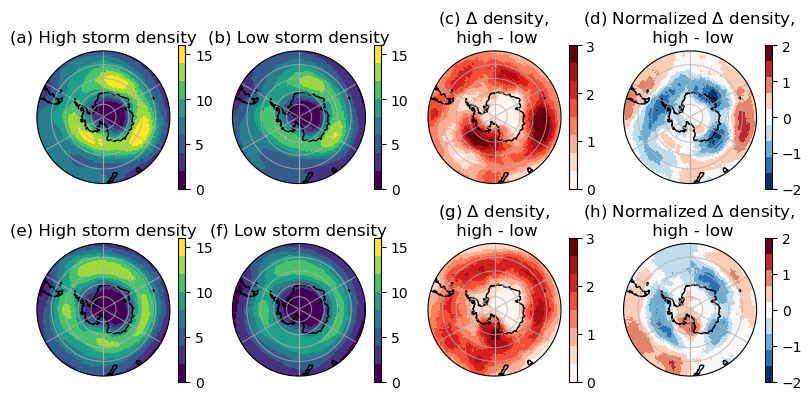

In [97]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=4,
    dpi=100,
    figsize=(8,4),
    subplot_kw={"projection": ccrs.SouthPolarStereo()},
)
axs = axs.flatten()

jja_hi.plot(
    ax=axs[0],
    transform=ccrs.PlateCarree(),
    vmax=16, extend='neither',
    cmap=plt.get_cmap('viridis', 8),
    cbar_kwargs={"label": ""},
)
axs[0].set_title('(a) High storm density')
#axs[0].text(-0.25, 0.55, 'JJA', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor', weight='bold',
#        transform=axs[0].transAxes)

jja_lo.plot(
    ax=axs[1],
    transform=ccrs.PlateCarree(),
    vmax=16, extend='neither',
    cmap=plt.get_cmap('viridis', 8),
    cbar_kwargs={"label": ""},
)
axs[1].set_title('(b) Low storm density')

(jja_hi-jja_lo).plot(
    ax=axs[2],
    transform=ccrs.PlateCarree(),
    vmin=0, vmax=3, extend='neither',
    cmap=plt.get_cmap("Reds", 8),
    cbar_kwargs={"label": ""},
)
axs[2].set_title('(c) $\Delta$ density, \n high - low')

(jja_hi_redist - jja_lo_redist).plot(
    ax=axs[3],
    transform=ccrs.PlateCarree(),
    vmin=-2, vmax=2, extend='neither',
    cmap=plt.get_cmap("RdBu_r", 9),
    cbar_kwargs={"label": ""},
)
axs[3].set_title('(d) Normalized $\Delta$ density, \n high - low')

djf_hi.plot(
    ax=axs[4],
    transform=ccrs.PlateCarree(),
    vmax=16, extend='neither',
    cmap=plt.get_cmap('viridis', 8),
    cbar_kwargs={"label": ""},
)
axs[4].set_title('(e) High storm density')

djf_lo.plot(
    ax=axs[5],
    transform=ccrs.PlateCarree(),
    vmax=16, extend='neither',
    cmap=plt.get_cmap('viridis', 8),
    cbar_kwargs={"label": ""},
)
axs[5].set_title('(f) Low storm density')

(djf_hi-djf_lo).plot(
    ax=axs[6],
    transform=ccrs.PlateCarree(),
    vmin=0, vmax=3, extend='neither',
    cmap=plt.get_cmap("Reds",8),
    cbar_kwargs={"label": ""},
)
axs[6].set_title('(g) $\Delta$ density, \n high - low')

(djf_hi_redist - djf_lo_redist).plot(
    ax=axs[7],
    transform=ccrs.PlateCarree(),
    vmin=-2, vmax=2, extend='neither',
    cmap=plt.get_cmap("RdBu_r",9),
    cbar_kwargs={"label": ""},
)
axs[7].set_title('(h) Normalized $\Delta$ density, \n high - low')

for i in range(8):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

plt.tight_layout()

plt.savefig(f"{out_path_fig}F1_storm_activity_{mod}-500.eps", format="eps")#, dpi=100)

In [35]:
# storm_dens_djf = (
#     ds_mask.mask[midx_djf, :, :].sum(dim="time") / ds_mask.mask[midx_djf, :, :].sum()
# )
# storm_dens_djf_hi = (
#     ds_mask.mask[midx_hi_djf, :, :].sum(dim="time")
#     / ds_mask.mask[midx_hi_djf, :, :].sum()
# )
# storm_dens_djf_lo = (
#     ds_mask.mask[midx_lo_djf, :, :].sum(dim="time")
#     / ds_mask.mask[midx_lo_djf, :, :].sum()
# )

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


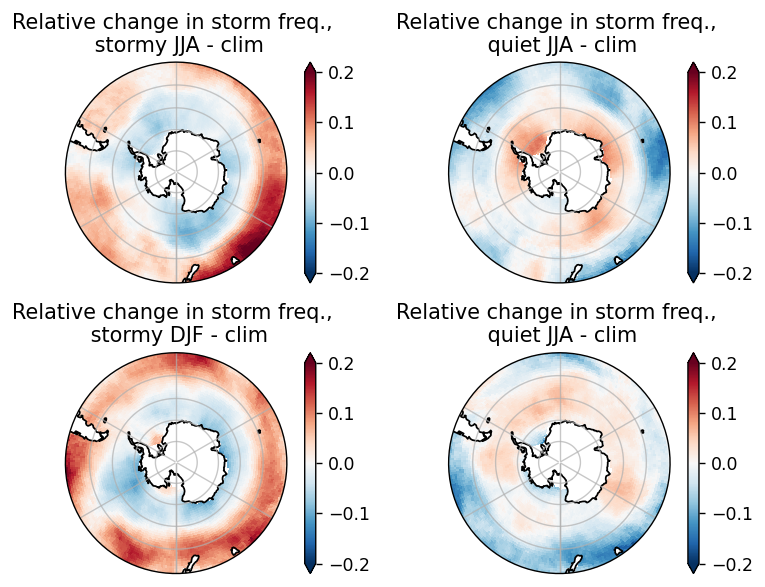

In [52]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    dpi=125,
    subplot_kw={"projection": ccrs.SouthPolarStereo()},
)
axs = axs.flatten()

((storm_dens_jja_hi - storm_dens_jja) / storm_dens_jja).plot(
    ax=axs[0],
    transform=ccrs.PlateCarree(),
    vmin=-0.2,
    vmax=0.2,
    cmap=plt.get_cmap("RdBu_r"),
)
axs[0].set_title("Relative change in storm freq., \n stormy JJA - clim")

((storm_dens_jja_lo - storm_dens_jja) / storm_dens_jja).plot(
    ax=axs[1],
    transform=ccrs.PlateCarree(),
    vmin=-0.2,
    vmax=0.2,
    cmap=plt.get_cmap("RdBu_r"),
)
axs[1].set_title("Relative change in storm freq., \n quiet JJA - clim")


((storm_dens_djf_hi - storm_dens_djf) / storm_dens_djf).plot(
    ax=axs[2],
    transform=ccrs.PlateCarree(),
    vmin=-0.2,
    vmax=0.2,
    cmap=plt.get_cmap("RdBu_r"),
)
axs[2].set_title("Relative change in storm freq., \n stormy DJF - clim")


((storm_dens_djf_lo - storm_dens_djf) / storm_dens_djf).plot(
    ax=axs[3],
    transform=ccrs.PlateCarree(),
    vmin=-0.2,
    vmax=0.2,
    cmap=plt.get_cmap("RdBu_r"),
)
axs[3].set_title("Relative change in storm freq., \n quiet JJA - clim")


for i in range(4):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

plt.tight_layout()

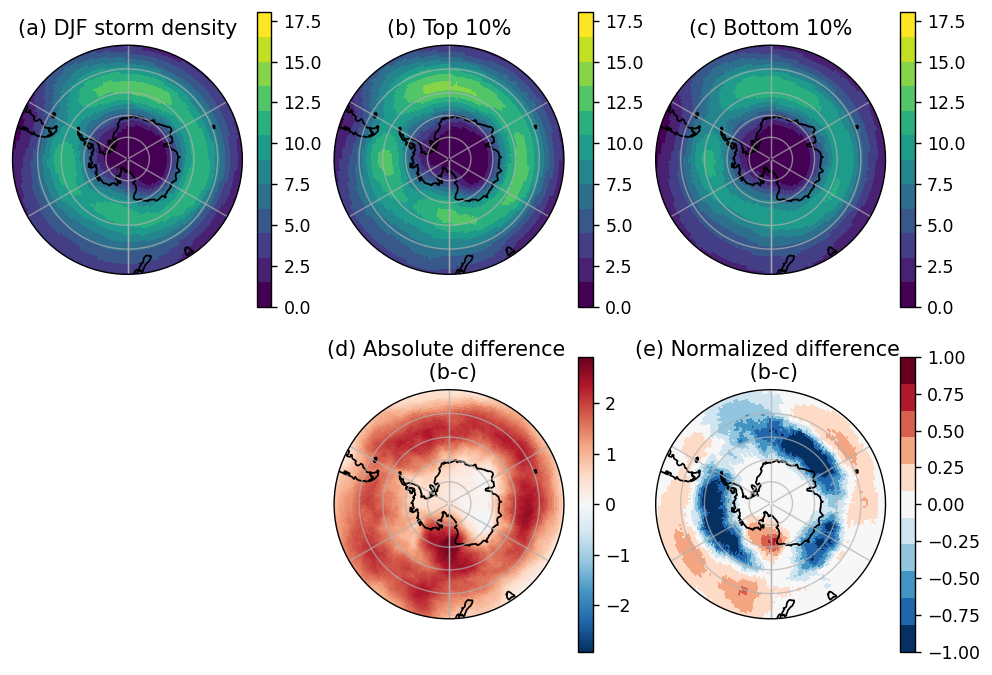

In [87]:
## Summer month storm activity

fig, axs = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(8, 5.5),
    dpi=125,
    subplot_kw={"projection": ccrs.SouthPolarStereo()},
)
axs = axs.flatten()


(1 / (3 * 500 * 4) * ds_mask.mask[midx_djf, :, :].sum(dim="time")).plot(
    ax=axs[0],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmax=18,
    extend="neither",
    cmap=plt.get_cmap("viridis", 12),
    cbar_kwargs={"label": ""},
)

axs[0].set_title("(a) DJF storm density")

(1 / (3 * 50 * 4) * ds_mask.mask[midx_hi_djf, :, :].sum(dim="time")).plot(
    ax=axs[1],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmax=18,
    extend="neither",
    cmap=plt.get_cmap("viridis", 12),
    cbar_kwargs={"label": ""},
)
axs[1].set_title("(b) Top 10%")

(1 / (3 * 50 * 4) * ds_mask.mask[midx_lo_djf, :, :].sum(dim="time")).plot(
    ax=axs[2],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmax=18,
    extend="neither",
    cmap=plt.get_cmap("viridis", 12),
    cbar_kwargs={"label": ""},
)

axs[2].set_title("(c) Bottom 10%")


# differences between high and low years

(
    1
    / (3 * 50 * 4)
    * (
        ds_mask.mask[midx_hi_djf, :, :].sum(dim="time")
        - ds_mask.mask[midx_lo_djf, :, :].sum(dim="time")
    )
).plot(
    ax=axs[4],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    # vmax=18, extend='neither',
    # cmap=plt.get_cmap('viridis', 12)
    cbar_kwargs={"label": ""},
)
axs[4].set_title("(d) Absolute difference \n (b-c)")

(
    (
        1 / 2318 * ds_mask.mask[midx_hi_djf, :, :].sum(dim="time")
        - 1 / 1861 * ds_mask.mask[midx_lo_djf, :, :].sum(dim="time")
    )
    / 1
    / 1861
    * ds_mask.mask[midx_lo_djf, :, :].sum(dim="time")
).plot(
    ax=axs[5],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-1,
    vmax=1,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
    cbar_kwargs={"label": ""},
)

axs[5].set_title("(e) Normalized difference \n (b-c)")


for i in range(6):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

axs[3].remove()
plt.tight_layout()

plt.savefig(f"{out_path_fig}storm_activity_djf_CM4-500.png", format="png", dpi=100)

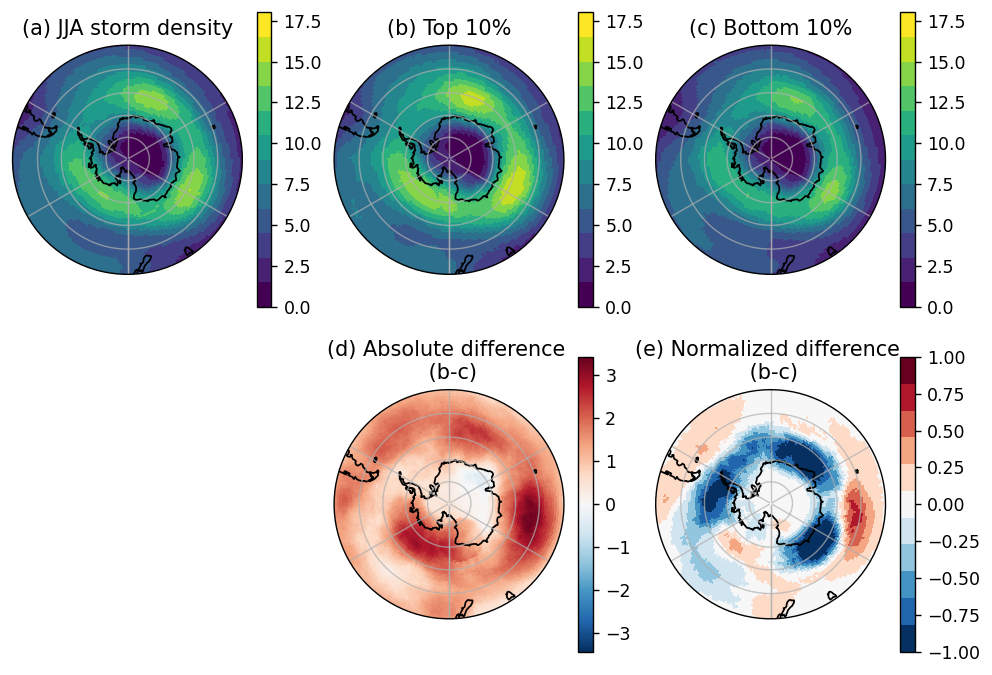

In [89]:
## Winter month storm activity

fig, axs = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(8, 5.5),
    dpi=125,
    subplot_kw={"projection": ccrs.SouthPolarStereo()},
)
axs = axs.flatten()


(1 / (3 * 500 * 4) * ds_mask.mask[midx_jja, :, :].sum(dim="time")).plot(
    ax=axs[0],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmax=18,
    extend="neither",
    cmap=plt.get_cmap("viridis", 12),
    cbar_kwargs={"label": ""},
)

axs[0].set_title("(a) JJA storm density")

(1 / (3 * 50 * 4) * ds_mask.mask[midx_hi_jja, :, :].sum(dim="time")).plot(
    ax=axs[1],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmax=18,
    extend="neither",
    cmap=plt.get_cmap("viridis", 12),
    cbar_kwargs={"label": ""},
)
axs[1].set_title("(b) Top 10%")

(1 / (3 * 50 * 4) * ds_mask.mask[midx_lo_jja, :, :].sum(dim="time")).plot(
    ax=axs[2],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmax=18,
    extend="neither",
    cmap=plt.get_cmap("viridis", 12),
    cbar_kwargs={"label": ""},
)

axs[2].set_title("(c) Bottom 10%")


# differences between high and low years

(
    1
    / (3 * 50 * 4)
    * (
        ds_mask.mask[midx_hi_jja, :, :].sum(dim="time")
        - ds_mask.mask[midx_lo_jja, :, :].sum(dim="time")
    )
).plot(
    ax=axs[4],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    # vmax=18, extend='neither',
    # cmap=plt.get_cmap('viridis', 12)
    cbar_kwargs={"label": ""},
)
axs[4].set_title("(d) Absolute difference \n (b-c)")

(
    (
        1 / 2704 * ds_mask.mask[midx_hi_jja, :, :].sum(dim="time")
        - 1 / 2205 * ds_mask.mask[midx_lo_jja, :, :].sum(dim="time")
    )
    / 1
    / 2205
    * ds_mask.mask[midx_lo_jja, :, :].sum(dim="time")
).plot(
    ax=axs[5],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-1,
    vmax=1,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
    cbar_kwargs={"label": ""},
)

axs[5].set_title("(e) Normalized difference \n (b-c)")


for i in range(6):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

axs[3].remove()
plt.tight_layout()

plt.savefig(f"{out_path_fig}storm_activity_jja_CM4-500.png", format="png", dpi=100)

## Mean latitude of storms in years and seasons -- does a scaling argument work? _upshot - not really_

In [54]:
df = pd.read_csv(
    "/work/Katherine.Turner/tempest-extremes/CM4_cmip/node_files/SH_stormtraj.csv",
    delimiter="\t",
)
df.loc[df["Month"].isin([1, 2]), "SeasonYear"] = df["Year"] - 1
df.loc[df["Month"].isin([3, 4, 5, 6, 7, 8, 9, 10, 11, 12]), "SeasonYear"] = df["Year"]

In [57]:
df_winter = df[df["Month"].isin([6, 7, 8])]
df_summer = df[df["Month"].isin([1, 2, 12])]

In [64]:
year_counts_winter = df_winter["SeasonYear"].value_counts().sort_index()
year_counts_summer = df_summer["SeasonYear"].value_counts().sort_index()

lat_winter = df_winter.groupby("SeasonYear")["Lat"].mean()
lat_summer = df_summer.groupby("SeasonYear")["Lat"].mean()

In [72]:
m, b = np.polyfit(year_counts_summer.iloc[1:-1], lat_summer.iloc[1:-1], deg=1)

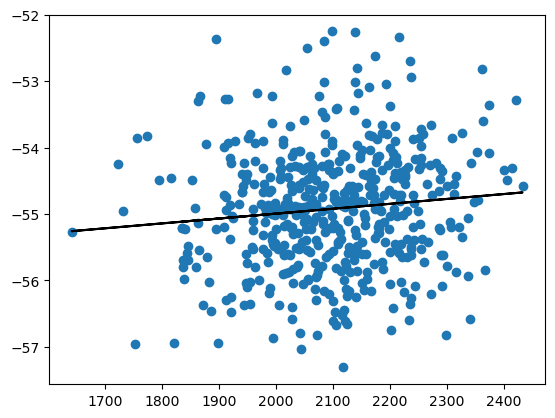

In [75]:
plt.scatter(year_counts_summer.iloc[1:-1], lat_summer.iloc[1:-1])
plt.plot(
    year_counts_summer.iloc[1:-1], b + m * year_counts_summer.iloc[1:-1], color="k"
)

## EOFs of storm track masks

In [138]:
ds_mask = xr.open_mfdataset(
    "/work/Katherine.Turner/tempest-extremes/ESM4_cmip/mask/mask_*.nc", use_cftime=True
)

In [139]:
mask_jja = ds_mask.mask.sel(lat=slice(-90, -30)).resample(time="QS-DEC").sum()[2::4]
mask_djf = ds_mask.mask.sel(lat=slice(-90, -30)).resample(time="QS-DEC").sum()[4:-4:4]

In [140]:
mask_jja = (mask_jja - mask_jja.mean(dim="time")).compute()
mask_djf = (mask_djf - mask_djf.mean(dim="time")).compute()

In [141]:
coslat = np.cos(np.deg2rad(mask_jja.coords["lat"].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

In [142]:
solver_jja = Eof(mask_jja, weights=wgts)
eof_jja = solver_jja.eofsAsCorrelation(neofs=2)
pc_jja = solver_jja.pcs(npcs=2, pcscaling=1)

solver_djf = Eof(mask_djf, weights=wgts)
eof_djf = solver_djf.eofsAsCorrelation(neofs=3)
pc_djf = solver_djf.pcs(npcs=3, pcscaling=1)

var_jja = solver_jja.varianceFraction()
var_djf = solver_djf.varianceFraction()

In [143]:
var_djf[:3]

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.10842048, 0.06698791, 0.06085931])
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions

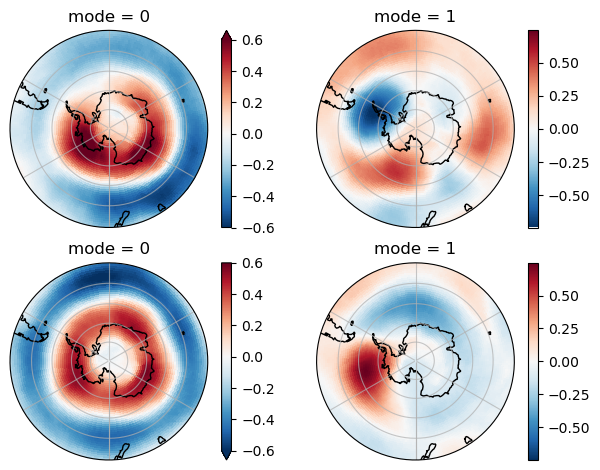

In [144]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    dpi=100,
    subplot_kw={"projection": ccrs.SouthPolarStereo()},
)
axs = axs.flatten()

eof_jja[0, :, :].plot(
    ax=axs[0],
    transform=ccrs.PlateCarree(),
    vmin=-0.6,
    vmax=0.6,
    cmap=plt.get_cmap("RdBu_r"),
    cbar_kwargs={"label": ""},
)

eof_jja[1, :, :].plot(
    ax=axs[1],
    transform=ccrs.PlateCarree(),
    # vmin=-0.2,
    # vmax=0.2,
    # cmap=plt.get_cmap("RdBu_r"),
    cbar_kwargs={"label": ""},
)

eof_djf[0, :, :].plot(
    ax=axs[2],
    transform=ccrs.PlateCarree(),
    vmin=-0.6,
    vmax=0.6,
    cmap=plt.get_cmap("RdBu_r"),
    cbar_kwargs={"label": ""},
)

eof_djf[1, :, :].plot(
    ax=axs[3],
    transform=ccrs.PlateCarree(),
    # vmin=-0.2,
    # vmax=0.2,
    # cmap=plt.get_cmap("RdBu_r"),
    cbar_kwargs={"label": ""},
)

for i in range(4):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

plt.tight_layout()

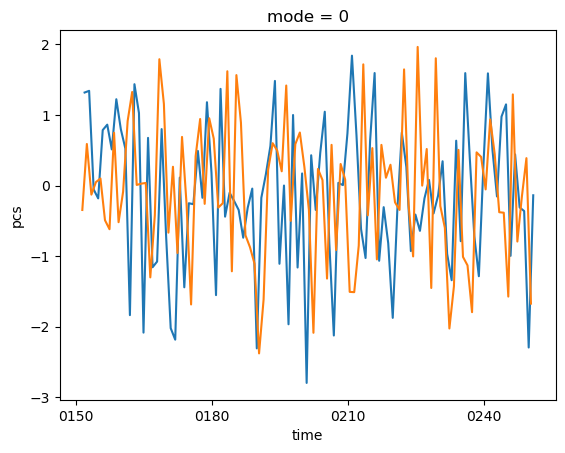

In [129]:
pc_djf[:100, 0].plot()
# pc_djf[:100,1].plot()

pc_jja[:100, 0].plot()
# pc_jja[:100,1].plot()

In [146]:
mod = "ESM4_cmip"
fpath = "/work/Katherine.Turner/smaller_projects/hifreq-variability/data"

ds_storms = xr.open_dataset(f"{fpath}/{mod}_monthly_storms.nc", use_cftime=True)
ds_SAM_djf = xr.open_dataset(f"{fpath}/{mod}_DJF_SAM.nc", use_cftime=True)
ds_SAM_jja = xr.open_dataset(f"{fpath}/{mod}_JJA_SAM.nc", use_cftime=True)
ds_NINO = xr.open_dataset(f"{fpath}/{mod}_nino34.nc", use_cftime=True)

In [147]:
for i in range(3):
    print(xr.corr(ds_SAM_djf.pcs, pc_djf[:, i]))

<xarray.DataArray 'pcs' ()>
array(0.89146845)
<xarray.DataArray 'pcs' ()>
array(-0.04860247)
<xarray.DataArray 'pcs' ()>
array(0.03336101)


In [148]:
for i in range(2):
    print(xr.corr(ds_SAM_jja.pcs, pc_jja[:, i]))

<xarray.DataArray 'pcs' ()>
array(0.7917189)
<xarray.DataArray 'pcs' ()>
array(-0.11319375)


In [149]:
for i in range(6, 15):
    NINO = ds_NINO.nino34[i:-6:12]
    print(np.corrcoef(NINO.data, pc_djf[:, 0].data)[1, 0])

-0.07322595054578017
-0.05540153050736804
-0.04921466926207815
-0.07119434393051667
-0.07683979704400382
-0.08580862902116734
-0.09332142585771384
-0.116369144814762
-0.12796257776096645
